# Tessera-PQC  —  Interactive Demo

> **Atomic Post-Quantum Cryptography on Intermittent-Power (battery-free IoT) Devices**

This notebook walks through all four research phases:

| Phase | Topic |
|-------|-------|
| 1 | Number Theoretic Transform (NTT) — math engine |
| 2 | Baby-Kyber KEM — key exchange |
| 3 | Atomic Scheduler — surviving power failures |
| 4 | Hamming-Weight Leakage — side-channel trace |

In [1]:
import sys, os
sys.path.insert(0, os.path.join('..', 'src'))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import simpy

from tessera.core.math       import PolynomialRing
from tessera.core.primitives import LatticeKEM
from tessera.hardware.power  import PowerSource
from tessera.hardware.memory import NonVolatileMemory
from tessera.scheduler       import AtomicTaskScheduler

plt.rcParams.update({'figure.dpi': 110, 'font.size': 11})
print('Tessera-PQC loaded ✓')

Tessera-PQC loaded ✓


---
## Phase 1 — NTT Round-Trip Verification

The Number Theoretic Transform works over the ring $R_q = \mathbb{Z}_q[X] / (X^n + 1)$  
with $n = 256$, $q = 3329$.  
We verify: $\text{inv\_ntt}(\text{ntt}(x)) \equiv x \pmod{q}$ for random polynomials.

In [2]:
ring = PolynomialRing()          # n=256, q=3329
rng  = np.random.default_rng(42)

N_TESTS = 10
results = []

for i in range(N_TESTS):
    x   = rng.integers(0, ring.q, ring.n, dtype=np.int64)
    rec = ring.inv_ntt(ring.ntt(x))
    ok  = np.all(rec == x % ring.q)
    results.append(ok)
    status = '✓ PASS' if ok else '✗ FAIL'
    print(f'  Trial {i+1:2d}:  input[:4]={list(x[:4])}  →  recovered[:4]={list(rec[:4])}  [{status}]')

print(f'\nResult: {sum(results)}/{N_TESTS} tests passed')

  Trial  1:  input[:4]=[np.int64(297), np.int64(2576), np.int64(2179), np.int64(1461)]  →  recovered[:4]=[np.int64(297), np.int64(2576), np.int64(2179), np.int64(1461)]  [✓ PASS]
  Trial  2:  input[:4]=[np.int64(2256), np.int64(344), np.int64(583), np.int64(1956)]  →  recovered[:4]=[np.int64(2256), np.int64(344), np.int64(583), np.int64(1956)]  [✓ PASS]
  Trial  3:  input[:4]=[np.int64(2799), np.int64(2718), np.int64(3192), np.int64(350)]  →  recovered[:4]=[np.int64(2799), np.int64(2718), np.int64(3192), np.int64(350)]  [✓ PASS]
  Trial  4:  input[:4]=[np.int64(465), np.int64(1252), np.int64(2170), np.int64(3284)]  →  recovered[:4]=[np.int64(465), np.int64(1252), np.int64(2170), np.int64(3284)]  [✓ PASS]
  Trial  5:  input[:4]=[np.int64(2736), np.int64(184), np.int64(258), np.int64(934)]  →  recovered[:4]=[np.int64(2736), np.int64(184), np.int64(258), np.int64(934)]  [✓ PASS]
  Trial  6:  input[:4]=[np.int64(2463), np.int64(2461), np.int64(1309), np.int64(2666)]  →  recovered[:4]=[np.i

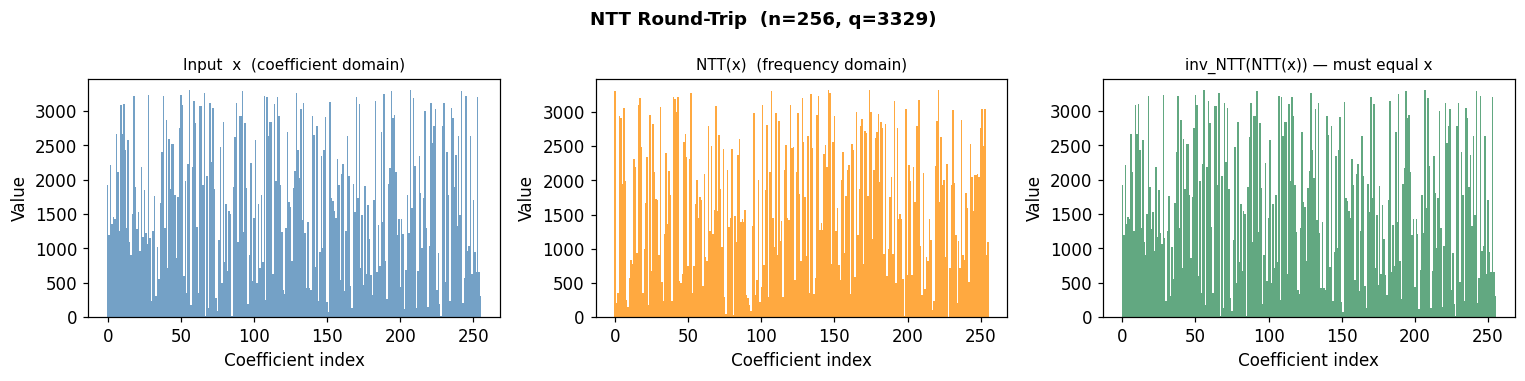

Max error: 0 (must be 0)


In [3]:
# Visualise one polynomial before and after NTT
x   = rng.integers(0, ring.q, ring.n, dtype=np.int64)
xn  = ring.ntt(x)
xr  = ring.inv_ntt(xn)

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5), sharey=False)
for ax, arr, title, color in zip(axes,
        [x, xn, xr],
        ['Input  x  (coefficient domain)', 'NTT(x)  (frequency domain)', 'inv_NTT(NTT(x)) — must equal x'],
        ['steelblue', 'darkorange', 'seagreen']):
    ax.bar(range(ring.n), arr, color=color, alpha=0.75, width=1.0)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Coefficient index')
    ax.set_ylabel('Value')
    ax.axhline(0, color='k', linewidth=0.5)

fig.suptitle(f'NTT Round-Trip  (n={ring.n}, q={ring.q})', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../ntt_roundtrip.png', bbox_inches='tight')
plt.show()
print(f'Max error: {np.max(np.abs(x % ring.q - xr))} (must be 0)')

---
## Phase 2 — Baby-Kyber KEM

Module-LWE KEM with parameters $k=2,\ n=256,\ q=3329,\ \eta=2$.  
**keygen → encaps → decaps** must recover the same 256-bit shared secret.

In [4]:
kem = LatticeKEM(ring)

TRIALS = 8
matches = []

print(f'{"Trial":>6}  {"pk":>8}  {"sk":>8}  {"ct":>8}  {"ss_enc[:8]":>20}  {"ss_dec[:8]":>20}  Result')
print('-' * 85)

for i in range(1, TRIALS + 1):
    pk, sk     = kem.keygen()
    ct, ss_enc = kem.encaps(pk)
    ss_dec     = kem.decaps(sk, ct)
    ok         = ss_enc == ss_dec
    matches.append(ok)
    print(f'{i:>6}  {len(pk):>8}  {len(sk):>8}  {len(ct):>8}  '
          f'{ss_enc.hex()[:16]:>20}  {ss_dec.hex()[:16]:>20}  '
          f'{"✓ MATCH" if ok else "✗ FAIL"}')

print(f'\n{sum(matches)}/{TRIALS} shared-secret pairs matched')

 Trial        pk        sk        ct            ss_enc[:8]            ss_dec[:8]  Result
-------------------------------------------------------------------------------------
     1       672       768       768      8f95c46edecb5ea2      8f95c46edecb5ea2  ✓ MATCH
     2       672       768       768      ba1be525a193f6fe      ba1be525a193f6fe  ✓ MATCH
     3       672       768       768      d608998c8713b166      d608998c8713b166  ✓ MATCH
     4       672       768       768      158c1a25f4d2aa73      158c1a25f4d2aa73  ✓ MATCH
     5       672       768       768      ccdd28c5b01e34b3      ccdd28c5b01e34b3  ✓ MATCH
     6       672       768       768      ba4c011340b26690      ba4c011340b26690  ✓ MATCH
     7       672       768       768      c195c5282bd4789b      c195c5282bd4789b  ✓ MATCH
     8       672       768       768      dc857c23d068c69e      dc857c23d068c69e  ✓ MATCH

8/8 shared-secret pairs matched


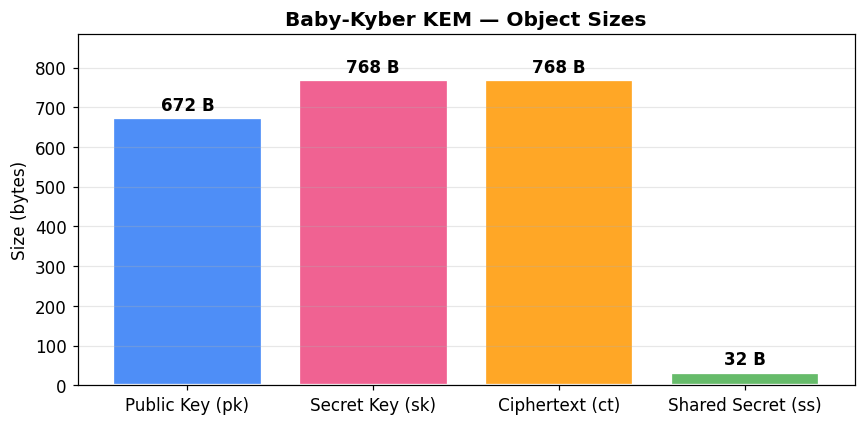

In [5]:
# Visualise one KEM flow as a bar chart of key/ct sizes
labels  = ['Public Key (pk)', 'Secret Key (sk)', 'Ciphertext (ct)', 'Shared Secret (ss)']
pk, sk  = kem.keygen()
ct, ss  = kem.encaps(pk)
sizes   = [len(pk), len(sk), len(ct), len(ss)]
colors  = ['#4e8ef7', '#f06292', '#ffa726', '#66bb6a']

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(labels, sizes, color=colors, edgecolor='white', linewidth=1.5)
for bar, val in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10,
            f'{val} B', ha='center', va='bottom', fontweight='bold')
ax.set_ylabel('Size (bytes)')
ax.set_title('Baby-Kyber KEM — Object Sizes', fontweight='bold')
ax.set_ylim(0, max(sizes) * 1.15)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../kem_sizes.png', bbox_inches='tight')
plt.show()

---
## Phase 3 — Atomic NTT Scheduler  (SimPy)

The scheduler breaks the NTT into **8 atomic layers**.  
Before each layer it checks power; if off, it blocks on `power_restored`.  
After each layer it writes a **checkpoint** to NVM so work survives failures.

We collect the complete power timeline to visualise the chaos.

In [6]:
import random
random.seed(5)

ON_AVG  = 90    # mean powered-on duration
OFF_AVG = 35    # mean powered-off duration
SIM_DUR = 1200  # total simulation time

env   = simpy.Environment()
power = PowerSource(env, on_time_avg=ON_AVG, off_time_avg=OFF_AVG)
nvm   = NonVolatileMemory()
sched = AtomicTaskScheduler(env, power, nvm, ring)

poly  = np.random.randint(0, ring.q, ring.n, dtype=np.int64)

# Collect a power timeline for plotting
power_timeline: list[tuple[float, int]] = [(0.0, 1)]
_orig_cycle = power._power_cycle_process

env.process(sched.run_atomic_ntt(poly_data=poly))
env.run(until=SIM_DUR)

print(f'Completed layers : {sched.completed_layers} / 8')
print(f'Power failures   : {sched.power_failures}')
print(f'NVM restores     : {sched.restores}')
print(f'NVM writes       : {len(nvm.leakage_trace)}')
print(f'Leakage summary  : {nvm.summary()}')

[Scheduler] Starting Atomic NTT at t=0.0 | Layers: 8 | Starting from layer 0
[Scheduler] Layer 1/8 complete (t=15.0)
[Scheduler] Layer 2/8 complete (t=30.0)
[Scheduler] Layer 3/8 complete (t=45.0)
[Scheduler] Layer 4/8 complete (t=60.0)
[Scheduler] Layer 5/8 complete (t=75.0)
[HW] Power FAILURE at 87.77
[Scheduler] Layer 6/8 complete (t=90.0)
[Scheduler] Power FAILURE before layer 6 (t=90.0) — waiting...
[HW] Power RESTORED at 135.16
[Scheduler] Resuming at layer 6 (t=135.2)
[Scheduler] Layer 7/8 complete (t=150.2)
[Scheduler] Layer 8/8 complete (t=165.2)
[Scheduler] NTT COMPLETE at t=165.2 | Failures: 1 | Restores: 1
[HW] Power FAILURE at 277.87
[HW] Power RESTORED at 377.80
[HW] Power FAILURE at 499.00
[HW] Power RESTORED at 588.44
[HW] Power FAILURE at 591.09
[HW] Power RESTORED at 613.02
[HW] Power FAILURE at 871.41
[HW] Power RESTORED at 908.05
[HW] Power FAILURE at 1116.09
[HW] Power RESTORED at 1120.30
[HW] Power FAILURE at 1177.28
[HW] Power RESTORED at 1187.19
Completed layers

---
## Phase 4 — Hamming-Weight Leakage Trace

Every NVM write leaks power proportional to the **Hamming Weight** of the data written.  
An attacker can correlate this trace against key hypotheses (Differential Power Analysis).

In [7]:
# Run a fresh, clean simulation to get a clear leakage trace
random.seed(7)

env2   = simpy.Environment()
power2 = PowerSource(env2, on_time_avg=200, off_time_avg=50)
nvm2   = NonVolatileMemory()
sched2 = AtomicTaskScheduler(env2, power2, nvm2, ring)
poly2  = np.random.randint(0, ring.q, ring.n, dtype=np.int64)

env2.process(sched2.run_atomic_ntt(poly_data=poly2))
env2.run(until=5000)

times  = nvm2.times()
powers = nvm2.power_values()

print(f'Leakage samples : {len(times)}')
print(f'HW range        : {min(powers)} – {max(powers)} bits')
print(f'HW mean         : {sum(powers)/len(powers):.1f} bits')

[Scheduler] Starting Atomic NTT at t=0.0 | Layers: 8 | Starting from layer 0
[Scheduler] Layer 1/8 complete (t=15.0)
[Scheduler] Layer 2/8 complete (t=30.0)
[Scheduler] Layer 3/8 complete (t=45.0)
[Scheduler] Layer 4/8 complete (t=60.0)
[Scheduler] Layer 5/8 complete (t=75.0)
[HW] Power FAILURE at 78.26
[HW] Power RESTORED at 86.44
[Scheduler] Layer 6/8 complete (t=90.0)
[Scheduler] Layer 7/8 complete (t=105.0)
[Scheduler] Layer 8/8 complete (t=120.0)
[Scheduler] NTT COMPLETE at t=120.0 | Failures: 0 | Restores: 0
[HW] Power FAILURE at 296.94
[HW] Power RESTORED at 300.70
[HW] Power FAILURE at 454.22
[HW] Power RESTORED at 476.98
[HW] Power FAILURE at 488.93
[HW] Power RESTORED at 524.34
[HW] Power FAILURE at 531.98
[HW] Power RESTORED at 560.41
[HW] Power FAILURE at 574.89
[HW] Power RESTORED at 579.65
[HW] Power FAILURE at 690.16
[HW] Power RESTORED at 777.84
[HW] Power FAILURE at 804.27
[HW] Power RESTORED at 816.90
[HW] Power FAILURE at 1014.37
[HW] Power RESTORED at 1161.91
[HW] P

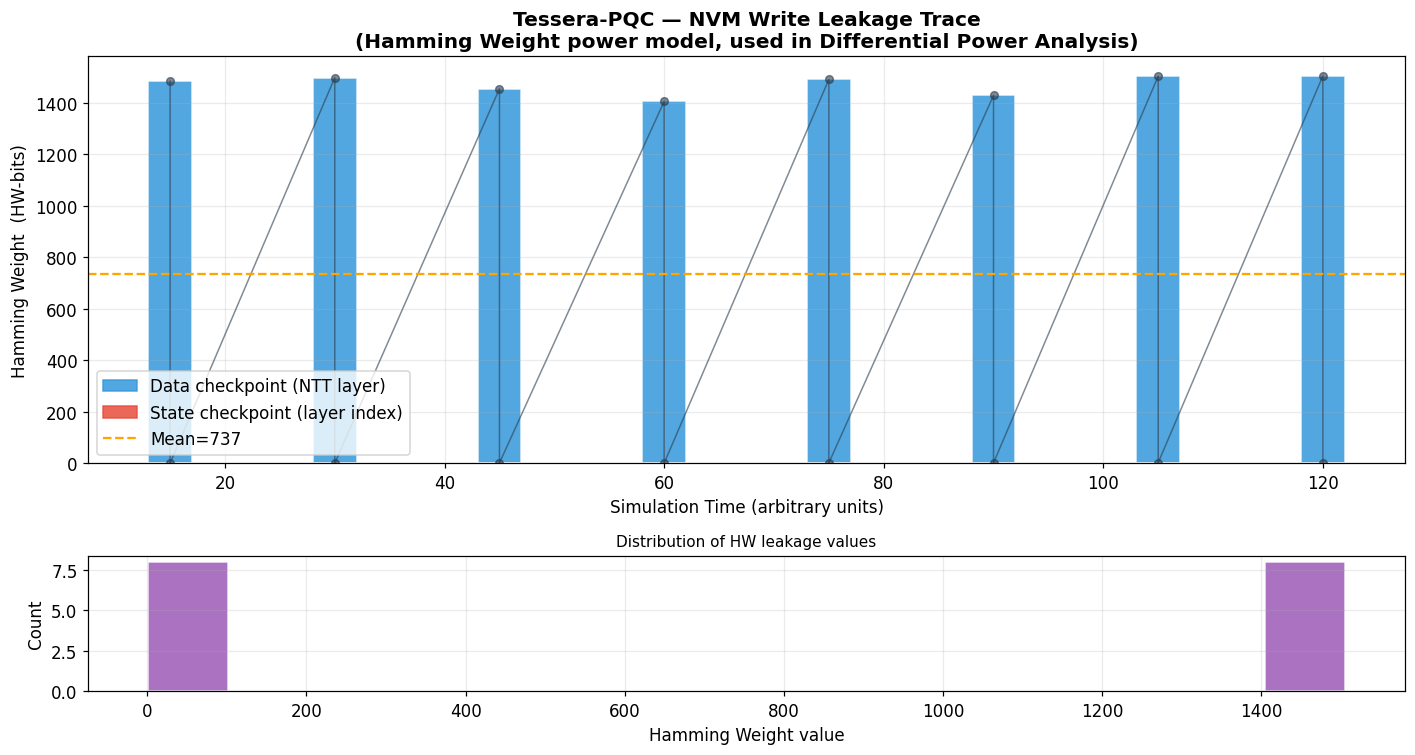

Saved → ../leakage_trace.png


In [8]:
fig, axes = plt.subplots(2, 1, figsize=(13, 7), gridspec_kw={'height_ratios': [3, 1]})

# ── Top: Leakage Trace ──────────────────────────────────────────────────────
ax = axes[0]
# Colour checkpoints: state checkpoints (odd indices) vs data checkpoints (even)
colors_hw = ['#e74c3c' if i % 2 == 1 else '#3498db' for i in range(len(times))]
ax.bar(times, powers, width=4, color=colors_hw, alpha=0.85, edgecolor='white')
ax.plot(times, powers, 'o-', color='#2c3e50', markersize=5, linewidth=1, alpha=0.6)
ax.axhline(sum(powers) / len(powers), color='orange', linestyle='--',
           linewidth=1.5, label=f'Mean = {sum(powers)/len(powers):.0f} HW-bits')
ax.set_xlabel('Simulation Time (arbitrary units)')
ax.set_ylabel('Hamming Weight  (HW-bits)')
ax.set_title('Tessera-PQC — NVM Write Leakage Trace\n'
             '(Hamming Weight power model, used in Differential Power Analysis)',
             fontweight='bold')
ax.legend()
ax.grid(alpha=0.25)
blue_p = mpatches.Patch(color='#3498db', alpha=0.85, label='Data checkpoint (NTT layer)')
red_p  = mpatches.Patch(color='#e74c3c', alpha=0.85, label='State checkpoint (layer index)')
ax.legend(handles=[blue_p, red_p,
    plt.Line2D([0],[0], color='orange', linestyle='--', label=f'Mean={sum(powers)/len(powers):.0f}')])

# ── Bottom: Power distribution histogram ───────────────────────────────────
ax2 = axes[1]
ax2.hist(powers, bins=15, color='#9b59b6', edgecolor='white', alpha=0.85)
ax2.set_xlabel('Hamming Weight value')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of HW leakage values', fontsize=10)
ax2.grid(alpha=0.25)

plt.tight_layout()
plt.savefig('../leakage_trace.png', bbox_inches='tight', dpi=140)
plt.show()
print('Saved → ../leakage_trace.png')

---
## Simulation with power timeline overlay

In [9]:
# Run one more simulation and record the power-on/off timeline
import random
random.seed(11)

layer_events: list[tuple[float, int]] = []    # (time, layer_completed)
failure_times: list[float] = []
restore_times: list[float] = []

env3   = simpy.Environment()
power3 = PowerSource(env3, on_time_avg=100, off_time_avg=45)
nvm3   = NonVolatileMemory()
ring3  = PolynomialRing()
sched3 = AtomicTaskScheduler(env3, power3, nvm3, ring3)

# Instrument NVM to capture layer completion times
_orig3 = nvm3.write_checkpoint
def _instr3(addr, data, t):
    _orig3(addr, data, t)
    if addr != sched3._STATE_ADDR:
        layer_events.append((t, addr + 1))
nvm3.write_checkpoint = _instr3

# Instrument power to capture failure/restore times
def _wrap_cycle():
    while True:
        dur = random.expovariate(1.0 / power3.on_time_avg)
        yield env3.timeout(dur)
        power3.is_powered = False
        failure_times.append(env3.now)
        power3.power_lost.succeed()
        power3.power_lost = env3.event()
        off = random.expovariate(1.0 / power3.off_time_avg)
        yield env3.timeout(off)
        power3.is_powered = True
        restore_times.append(env3.now)
        power3.power_restored.succeed()
        power3.power_restored = env3.event()

# Replace internal process
env3._queue.clear()
env3.process(_wrap_cycle())
poly3 = np.random.randint(0, ring3.q, ring3.n, dtype=np.int64)
env3.process(sched3.run_atomic_ntt(poly_data=poly3))
env3.run(until=3000)

print(f'Completed: {sched3.completed_layers}/8 layers in {env3.now:.1f} time units')
print(f'Failures: {len(failure_times)}  |  Layer events: {len(layer_events)}')

[Scheduler] Starting Atomic NTT at t=0.0 | Layers: 8 | Starting from layer 0
[Scheduler] Layer 1/8 complete (t=15.0)
[Scheduler] Layer 2/8 complete (t=30.0)
[Scheduler] Layer 3/8 complete (t=45.0)
[Scheduler] Layer 4/8 complete (t=60.0)
[Scheduler] Layer 5/8 complete (t=75.0)
[Scheduler] Power FAILURE before layer 5 (t=75.0) — waiting...
[Scheduler] Resuming at layer 5 (t=97.1)
[Scheduler] Layer 6/8 complete (t=112.1)
[Scheduler] Layer 7/8 complete (t=127.1)
[Scheduler] Layer 8/8 complete (t=142.1)
[Scheduler] NTT COMPLETE at t=142.1 | Failures: 1 | Restores: 1
Completed: 8/8 layers in 3000.0 time units
Failures: 19  |  Layer events: 8


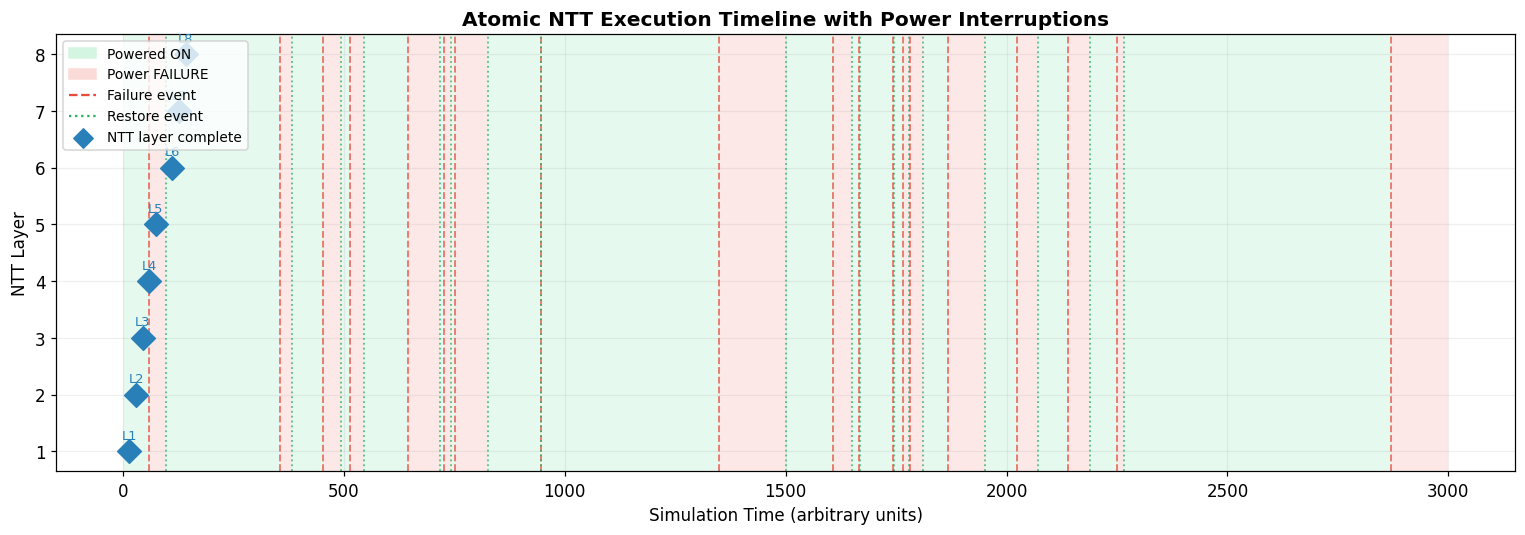

Saved → ../simulation_timeline.png


In [10]:
fig, ax = plt.subplots(figsize=(14, 5))

# Power background shading
t_max  = max(env3.now, 50)
events = sorted([(0, 'on')] +
                [(t, 'off') for t in failure_times] +
                [(t, 'on')  for t in restore_times])
prev_t = 0
prev_s = 'on'
for t, s in events[1:] + [(t_max, None)]:
    color = '#d5f5e3' if prev_s == 'on' else '#fadbd8'
    ax.axvspan(prev_t, t, facecolor=color, alpha=0.6, linewidth=0)
    prev_t, prev_s = t, s

# Layer completion markers
if layer_events:
    lt, ll = zip(*layer_events)
    ax.scatter(lt, ll, s=120, zorder=5, color='#2980b9', marker='D', label='Layer completed')
    for t_ev, lv in zip(lt, ll):
        ax.annotate(f'L{lv}', (t_ev, lv), textcoords='offset points',
                    xytext=(0, 8), ha='center', fontsize=8.5, color='#2980b9')

# Failure / restore vertical lines
for ft in failure_times:
    ax.axvline(ft, color='#e74c3c', linewidth=1.2, linestyle='--', alpha=0.75)
for rt in restore_times:
    ax.axvline(rt, color='#27ae60', linewidth=1.2, linestyle=':', alpha=0.75)

ax.set_xlabel('Simulation Time (arbitrary units)')
ax.set_ylabel('NTT Layer')
ax.set_yticks(range(1, ring3.n.bit_length()))
ax.set_title('Atomic NTT Execution Timeline with Power Interruptions', fontweight='bold')

handles = [
    mpatches.Patch(color='#d5f5e3', label='Powered ON'),
    mpatches.Patch(color='#fadbd8', label='Power FAILURE'),
    plt.Line2D([0],[0], color='#e74c3c', linestyle='--', label='Failure event'),
    plt.Line2D([0],[0], color='#27ae60', linestyle=':', label='Restore event'),
    plt.scatter([],[], s=80, color='#2980b9', marker='D', label='NTT layer complete'),
]
ax.legend(handles=handles, loc='upper left', fontsize=9)
ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('../simulation_timeline.png', bbox_inches='tight', dpi=140)
plt.show()
print('Saved → ../simulation_timeline.png')